# Introduction
## Confounders in the context of AI and statistical modeling
## Why is it important to address confounders in machine learning models

In [118]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from ucimlrepo import fetch_ucirepo

from pymatch.Matcher import Matcher

## Data

* age: continous, unit = years
* sex: categorical, 1 = male , 0 = female
* cp: categorical, chest pain type, 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
* trestbps: continous, resting blood pressure, unit = mm HG
* chol: continous, cholesterol, mg/dl
* fbs: categorical, fasting boold sugar, 1 = true, 0 = false (fbs > 120mg/dl)
* restecg: categorical, resting electrocardiographic results, 0 = normal, 1 = ST-T abnormality, 2 = probable/definite left ventricular hypertrophy
* thalach: continous, maximum heart rate achieved
* exang: categorical, exercise induced angine, 0 = fale, 1 = true
* oldpeak: continous, ST depression induced by exercise relatove to rest
* slope: categorical, slope of peak exercise ST segment, 1 = upsloping, 2= flat, 3 = downsloping
* ca: categorical?, number of major vessels, 0, 1, 2, 3
* thal: categorical, 3 = normal, 6 = fixed defect, 7 = reversable defect
* num: categorical, diagnisis of heard disease, 0 = false, 1 = true

In [119]:
# Load the data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
data = pd.read_csv(url, names=columns, na_values="?")

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## EDA
In the EDA we have a first look at the data and try to figure out possible confounders. 

In [120]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [122]:
# Handle missing values
data['ca'] = data['ca'].fillna(data['ca'].mode()[0])
data['thal'] = data['thal'].fillna(data['thal'].mode()[0])

# Recode 'num' to a binary format according to the documentation
data['num'] = data['num'].apply(lambda x: 1 if x > 0 else 0)

data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

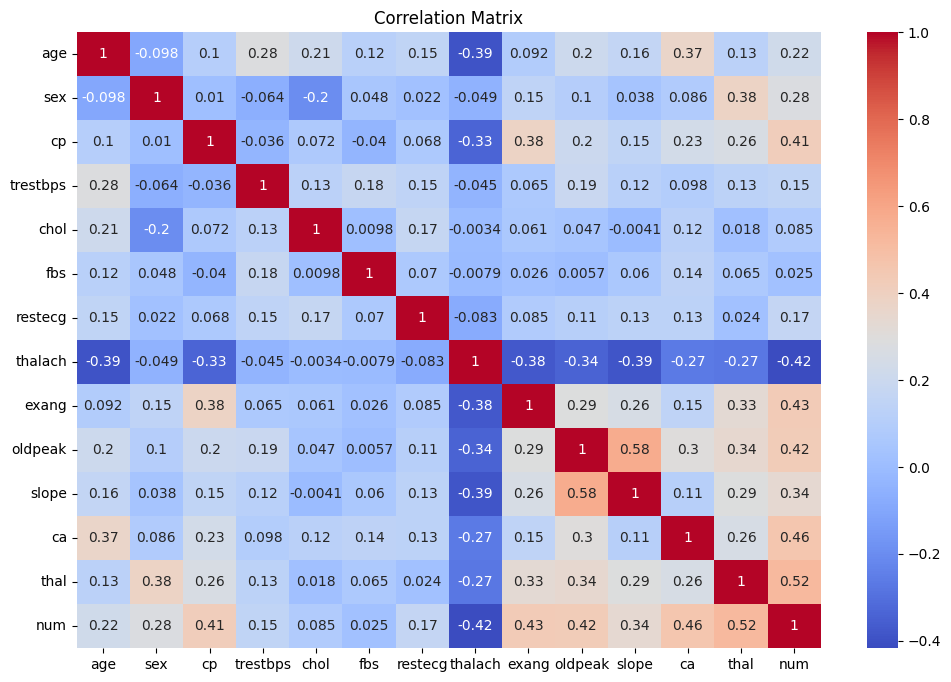

In [123]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

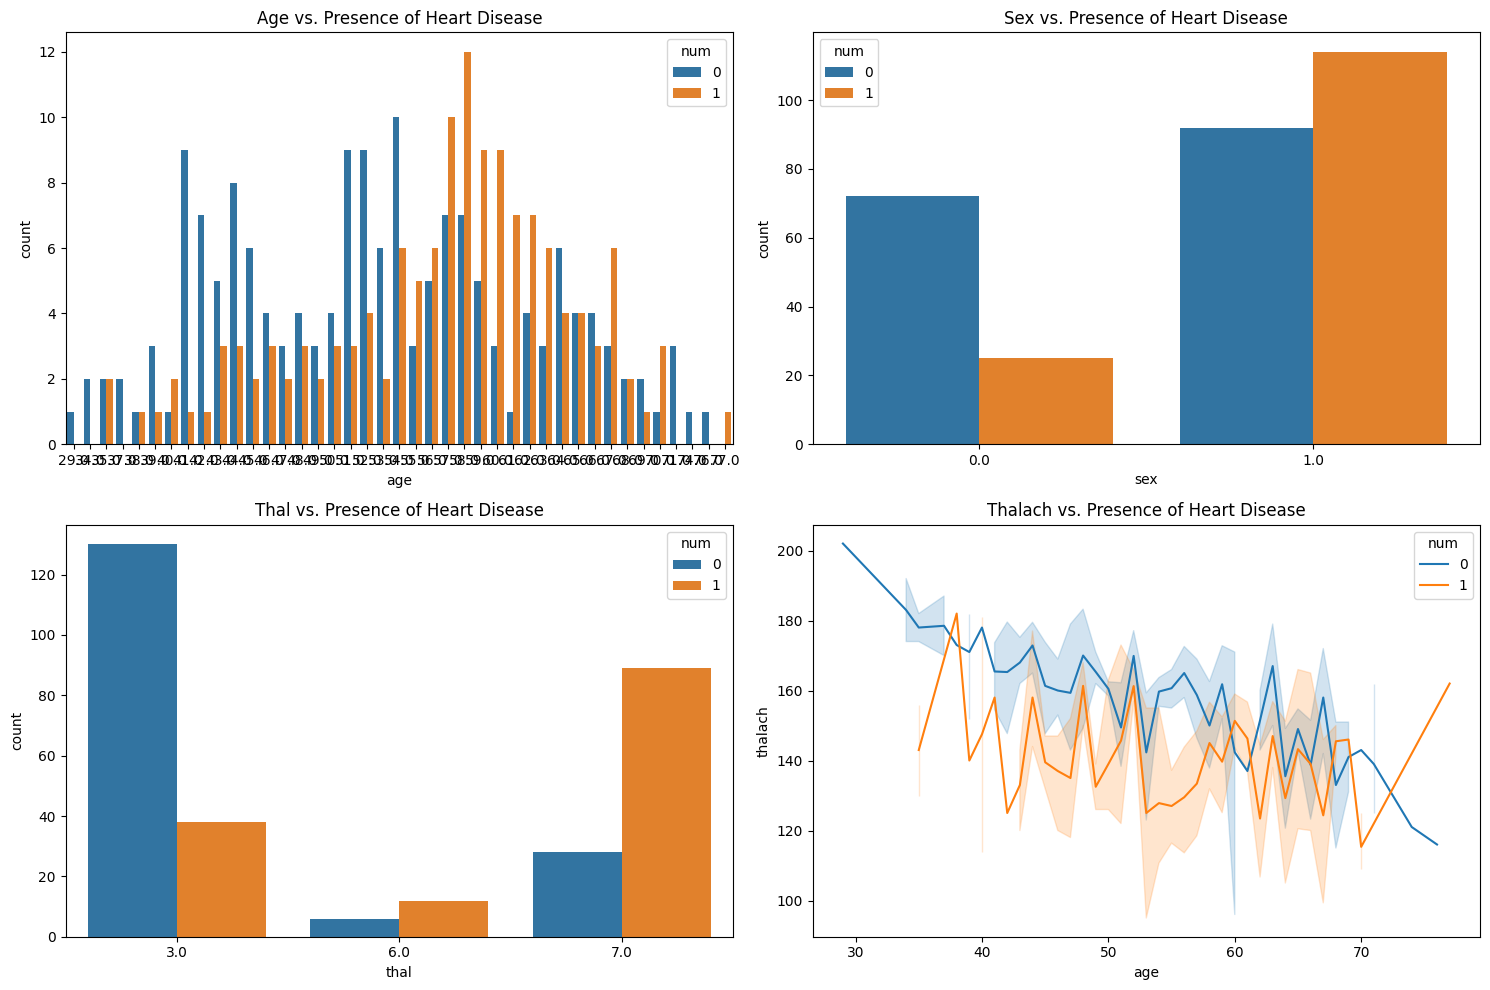

In [124]:
# EDA for potential confounders
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Age vs. Presence of Heart Disease
sns.countplot(ax=axes[0, 0], x='age', hue='num', data=data)
axes[0, 0].set_title('Age vs. Presence of Heart Disease')

# Sex vs. Presence of Heart Disease
sns.countplot(ax=axes[0, 1], x='sex', hue='num', data=data)
axes[0, 1].set_title('Sex vs. Presence of Heart Disease')

# Thal vs. Presence of Heart Disease
sns.countplot(ax=axes[1, 0], x='thal', hue='num', data=data)
axes[1, 0].set_title('Thal vs. Presence of Heart Disease')

# Thalach vs. Presence of Heart Disease
sns.lineplot(ax=axes[1, 1], x='age', y='thalach', hue='num', data=data)
axes[1, 1].set_title('Thalach vs. Presence of Heart Disease')

plt.tight_layout()
plt.show()

#### EDA Results:
### Age vs. Presence of Heart Disease: 
This plot shows the count of individuals within each age group categorized by their heart disease status (ranging from 0, indicating no presence, to 4, indicating a high presence). It seems that as age increases, the occurrence of heart disease also tends to increase. This trend is particularly visible in the age range from about 50 to 60 years. Age could be a confounder because it is related to both the risk of heart disease and potentially to other variables (like cholesterol levels, blood pressure, etc.).

### Sex vs. Presence of Heart Disease: 
The distribution between males (1) and females (0) shows that a higher number of males are represented in the dataset, and within males, there's a higher count across the different heart disease statuses. It implies that there might be a sex-related difference in heart disease presence in the dataset, which could affect the model if sex is related to other predictors.

### Thal vs. Presence of Heart Disease: 
This plot shows the distribution of the thalium stress test result across different categories of heart disease presence. There's a visible difference in the count of heart disease presence between the different thal categories, with '7' (reversible defect) showing a higher presence of heart disease. This suggests that 'thal' may be associated with the outcome and could be considered a potential confounder.

### Thalach vs. Presence of Heart Disease: 
The line plot illustrates the relationship between age, maximum heart rate achieved (thalach), and the presence of heart disease. It seems there's a general trend of decreasing maximum heart rate with age, which is to be expected. However, the relationship between thalach and heart disease is less clear from this plot. We do not see a distinct separation between the lines for different heart disease statuses, suggesting that while thalach is related to heart disease, it may not independently affect other predictors, which would be necessary to consider it a confounder.

In summary, age and sex are likely confounders in predicting heart disease because they affect both the outcome and other predictors. Thal also appears to be a confounder because it affects the outcome and may be associated with other predictors (such as age). Thalach seems to be a strong predictor of heart disease but not necessarily a confounder because it does not appear to influence other predictors.

# Model without adjusting for confounders (Baseline Model)

In [125]:
X = data.drop('num', axis=1)
y = data['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

baseline_model = LogisticRegression(max_iter=10000)
baseline_model.fit(X_train, y_train)

baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_conf_matrix = confusion_matrix(y_test, baseline_predictions)
baseline_report = classification_report(y_test, baseline_predictions)

print(f"Baseline Model Accuracy: {baseline_accuracy}")
print(f"Baseline Model Confusion Matrix:\n{baseline_conf_matrix}")
print(f"Baseline Model Classification Report:\n{baseline_report}")

Baseline Model Accuracy: 0.9016393442622951
Baseline Model Confusion Matrix:
[[35  1]
 [ 5 20]]
Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       0.95      0.80      0.87        25

    accuracy                           0.90        61
   macro avg       0.91      0.89      0.90        61
weighted avg       0.91      0.90      0.90        61



# Adjusting for confounders
## Techniques
### stratification
### regression adjustment


In [126]:
confounders = ['age','sex','thal', 'thalach']
accuracy_scores = []

for confounder in confounders:
    X = data.drop(['num', confounder], axis=1)
    y = data['num']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    conf_matrix = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions)
    
    print(f"Model without {confounder} Accuracy: {accuracy}")
    print(f"Model without {confounder} Confusion Matrix:\n{conf_matrix}")
    print(f"Model without {confounder} Classification Report:\n{report}")
    print("\n")

Model without age Accuracy: 0.9016393442622951
Model without age Confusion Matrix:
[[35  1]
 [ 5 20]]
Model without age Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       0.95      0.80      0.87        25

    accuracy                           0.90        61
   macro avg       0.91      0.89      0.90        61
weighted avg       0.91      0.90      0.90        61



Model without sex Accuracy: 0.9016393442622951
Model without sex Confusion Matrix:
[[35  1]
 [ 5 20]]
Model without sex Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       0.95      0.80      0.87        25

    accuracy                           0.90        61
   macro avg       0.91      0.89      0.90        61
weighted avg       0.91      0.90      0.90        61



Model without thal Accuracy: 0.8688524590163934
Model wi

# Comparison Baseline vs. Adjusted Model

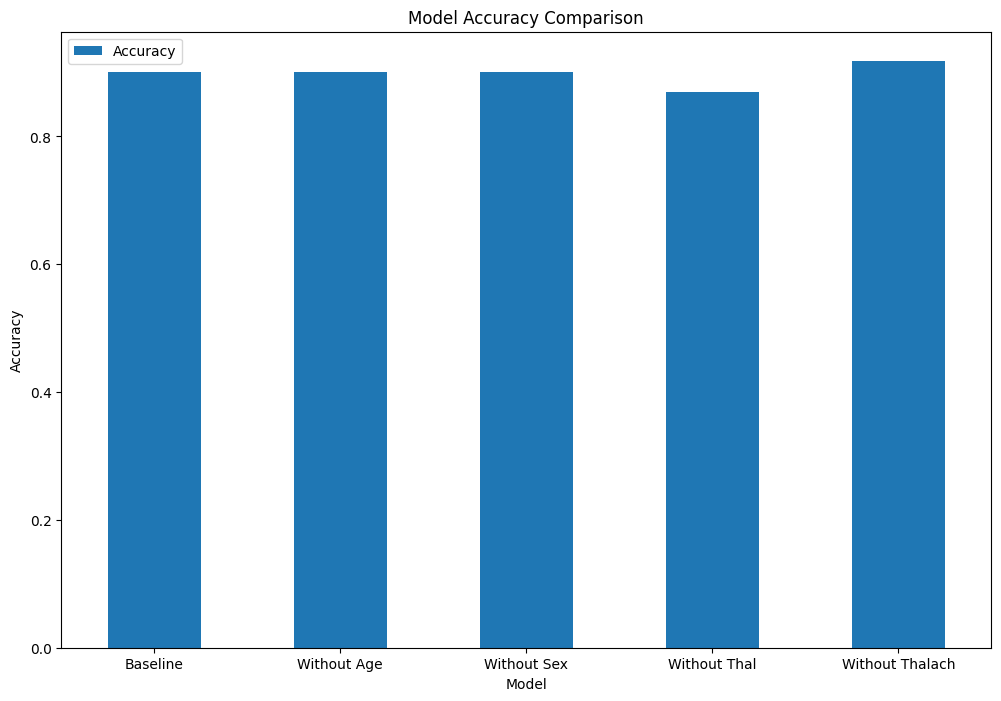

,Model,Accuracy
0,Baseline,0.901639
1,Without Age,0.901639
2,Without Sex,0.901639
3,Without Thal,0.868852
4,Without Thalach,0.918033


In [127]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline", "Without Age", "Without Sex", "Without Thal", "Without Thalach"],
    "Accuracy": [baseline_accuracy, accuracy_scores[0], accuracy_scores[1], accuracy_scores[2], accuracy_scores[3]] 
})

comparison_df.set_index("Model").plot(kind='bar', figsize=(12, 8))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.show()

comparison_df

1. Contextualizing Confounders: 
Start by explaining that confounders, like 'age', 'sex', and 'thal', can bias the model. For instance, 'age' and 'sex' might be associated with both the risk factors and the presence of heart disease, while 'thal' represents a diagnostic measure that could also be related to the severity of other risk factors.
2. Model Without Confounders: 
Discuss how the model excluding 'thal' (an important predictor that could also be a confounder due to its diagnostic nature) showed decreased accuracy. This indicates that 'thal' may have been contributing important information to the model that, when removed, leads to a loss of reliability in the prediction of heart disease.
3. Model Reliability: 
Discuss how the exclusion of 'thalach' surprisingly improved the model slightly, which suggests it might not be a confounder in this context. This is an interesting finding because it might have been expected that 'thalach', being correlated with the physical condition of a patient, would influence both the likelihood of having heart disease and be influenced by the same factors that lead to heart disease.
4. Interpretation and Reliability: 
Explain that addressing confounders is crucial for the interpretation of the model. If you don't account for confounders, you may attribute the effect on the outcome to the wrong predictors, or you may overestimate or underestimate the true effect of the predictors. This has significant implications for the trustworthiness of the model in a real-world setting, especially in critical fields like healthcare.
5. Techniques for Adjusting for Confounders: 
Discuss techniques used in AI for adjusting for confounders, such as including confounding variables in the model, matching, stratification, or using techniques like propensity score matching. Emphasize that the choice of technique depends on the context and the nature of the data.


For your paper, you might use this example to illustrate how subtle and complex the role of potential confounders can be in machine learning. You could discuss the unexpected results and explain why they do not diminish the importance of considering confounders in model building but rather highlight the need for careful analysis and domain expertise. Remember, the reliability of a model not only depends on its accuracy but also on how well it generalizes to new data and its ability to provide insights into the causal relationships between predictors and outcomes.

# Matching
In the context of your dataset and the task at hand, one form of matching you could use is propensity score matching.

Propensity score matching attempts to estimate the effect of a treatment, policy, or other intervention by accounting for the covariates that predict receiving the treatment. In machine learning and AI, this concept can be adapted to control for confounders when building predictive models.

Here's how you could approach propensity score matching in your example:

1. Compute Propensity Scores: 
First, you would need to compute the propensity score for each individual in your dataset, which is the probability of having a particular confounder given the observed covariates. In this case, you could compute the propensity score of being at a higher risk of heart disease based on age, sex, and thal.
2. Matching: 
After computing the scores, you would create pairs or groups of individuals with similar propensity scores—one group with the confounder present and one group without. For example, you might match males and females with similar age and thal scores but differing in the presence of heart disease.
3. Analysis on Matched Data: 
Once you have matched the data, you would then build your predictive model on the matched dataset. This model would theoretically be adjusted for the confounders because the matching process should balance out their influence across the groups being compared.
4. Interpretation: 
Finally, you would interpret the results of the model built on the matched data, highlighting how this approach can help mitigate the influence of confounders and potentially lead to more reliable and interpretable models.

Implementing propensity score matching in Python typically involves using a logistic regression model to calculate the propensity scores, followed by using a matching algorithm to pair up the subjects. Libraries such as scikit-learn for logistic regression and causalml or pymatch for matching can facilitate this process.

In [128]:
#Calculate the propensity score
X_conf = data.drop(['thal','num'], axis=1)
y_conf = data['thal']

logit_model = LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='multinomial')
logit_model.fit(X_conf, y_conf)
propensity_scores = logit_model.predict_proba(X_conf)
for i, class_label in enumerate(logit_model.classes_):
    data[f'propensity_score_{class_label}'] = propensity_scores[:, i]

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,propensity_score_3.0,propensity_score_6.0,propensity_score_7.0
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0.372430,0.268542,0.359028
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1,0.050022,0.155420,0.794558
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,0.147680,0.103108,0.749212
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0.246490,0.059775,0.693734
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0.972388,0.002144,0.025468


### Goal of Matching
Goal: The goal of matching is to form pairs or groups of subjects who are similar in terms of their propensity to receive each level of "thal", but may have received different treatments. This allows you to compare outcomes across similar subjects, reducing the impact of the confounding variable ("thal").

### Implementation
For each category of "thal", you'll perform matching. Since you have three categories (e.g., '3', '6', and '7'), you'll need to decide how to match:

One straightforward approach is to match each category against the rest. For example, match those with 'thal=3' against those with 'thal' not equal to 3, and similarly for the other categories.
Another approach is to match within categories, but this would require a larger sample size to ensure that there are enough matches within each category.

In [129]:
# Matching

def match(data, treatment_code, caliper=0.02):
    treatment = data[data['thal'] == treatment_code]
    control = data[data['thal'] != treatment_code]

    treatment = treatment.sort_values(f'propensity_score_{treatment_code}')
    control = control.sort_values(f'propensity_score_{treatment_code}')

    control['matched'] = False
    matches = []

    for i, row in treatment.iterrows():
        control['score_diff'] = np.abs(control[f'propensity_score_{treatment_code}'] - row[f'propensity_score_{treatment_code}'])
        potential_matches = control[(control['score_diff'] <= caliper) & (~control['matched'])]

        if not potential_matches.empty:
            match = potential_matches.loc[potential_matches['score_diff'].idxmin()]
            control.at[match.name, 'matched'] = True
            matches.append((row.name, match.name))
    
    return matches

In [130]:
matches_3 = match(data, 3.0)
matches_6 = match(data, 6.0)
matches_7 = match(data, 7.0)

In [131]:
def create_matched_dataset(data, matches):
    # Extract matched pairs into a new DataFrame
    matched_indices = [m for pair in matches for m in pair]  # Flatten the list of tuples
    matched_data = data.loc[matched_indices].copy()
    return matched_data

matched_data_3 = create_matched_dataset(data, matches_3)
matched_data_6 = create_matched_dataset(data, matches_6)
matched_data_7 = create_matched_dataset(data, matches_7)

In [132]:
def assess_balance(matched_data, treatment_code, covariates):
    # Split the matched data into treatment and control
    treatment = matched_data[matched_data['thal'] == treatment_code]
    control = matched_data[matched_data['thal'] != treatment_code]

    print(f"Balance for thal={treatment_code}:")
    print(f"{'Covariate':20s} {'Treatment Mean':15s} {'Control Mean':15s} {'Difference':15s}")
    
    for covariate in covariates:
        treat_mean = treatment[covariate].mean()
        control_mean = control[covariate].mean()
        diff = treat_mean - control_mean
        
        print(f"{covariate:20s} {treat_mean:15.2f} {control_mean:15.2f} {diff:15.2f}")

# List of covariates to check for balance
covariates = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
              'thalach', 'exang', 'oldpeak', 'slope', 'ca']

# Assess balance for each thal category matched dataset
assess_balance(matched_data_3, 3.0, covariates)
assess_balance(matched_data_6, 6.0, covariates)
assess_balance(matched_data_7, 7.0, covariates)

Balance for thal=3.0:
Covariate            Treatment Mean  Control Mean    Difference     
age                            55.16           53.79            1.37
sex                             0.81            0.84           -0.03
cp                              3.23            3.20            0.03
trestbps                      132.03          130.77            1.26
chol                          242.91          246.27           -3.36
fbs                             0.17            0.13            0.04
restecg                         0.99            0.84            0.14
thalach                       150.13          150.24           -0.11
exang                           0.39            0.39            0.00
oldpeak                         1.09            0.94            0.16
slope                           1.67            1.60            0.07
ca                              0.67            0.63            0.04
Balance for thal=6.0:
Covariate            Treatment Mean  Control Mean    Differ

In [133]:
def analyze_outcomes(matched_data, treatment_code):
    treatment = matched_data[matched_data['thal'] == treatment_code]
    control = matched_data[matched_data['thal'] != treatment_code]

    treatment_outcome_rate = treatment['num'].mean()
    control_outcome_rate = control['num'].mean()
    effect_size = treatment_outcome_rate - control_outcome_rate

    print(f"Outcomes for thal={treatment_code}:")
    print(f"Treatment Outcome Rate: {treatment_outcome_rate:.2f}")
    print(f"Control Outcome Rate: {control_outcome_rate:.2f}")
    print(f"Effect Size: {effect_size:.2f}")

# Perform outcome analysis for each matched dataset
analyze_outcomes(matched_data_3, 3.0)
analyze_outcomes(matched_data_6, 6.0)
analyze_outcomes(matched_data_7, 7.0)

Outcomes for thal=3.0:
Treatment Outcome Rate: 0.43
Control Outcome Rate: 0.64
Effect Size: -0.21
Outcomes for thal=6.0:
Treatment Outcome Rate: 0.65
Control Outcome Rate: 0.88
Effect Size: -0.24
Outcomes for thal=7.0:
Treatment Outcome Rate: 0.71
Control Outcome Rate: 0.48
Effect Size: 0.23


# Conclusion